## Time Series Analysis of Wikipedia Page Views (part 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.signal import periodogram
from scipy.signal import welch
from scipy.signal import stft

##### Additional functions:

In [3]:
def custom_grid(plt):
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.grid(True, linestyle='--', alpha=0.6)

#### Time series

In [4]:
df = pd.read_csv('page_views_dataframe.csv', index_col=0, parse_dates=True)
df.head(3)

,Views,Log_Views,Log_Diff
Date,,,
2015-07-01,133772,11.803892,NaN
2015-08-01,121582,11.708344,-0.095548
2015-09-01,93157,11.442042,-0.266303


Reminder:

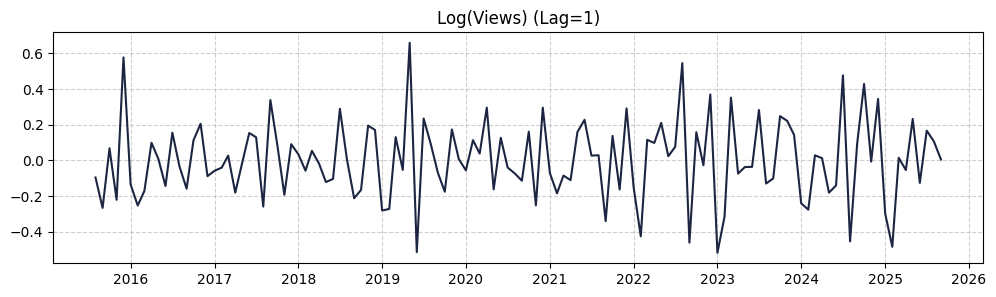

In [5]:
plt.figure(figsize=(12,3))
plt.plot(df["Log_Diff"], color="#1c2541")
plt.title("Log(Views) (Lag=1)")

custom_grid(plt)

plt.show()

### 1) Correlation analysis.

Substract mean:

In [6]:
log_diff = df['Log_Diff'].dropna().values
log_diff_mean = np.mean(log_diff)
log_diff_centered = log_diff - log_diff_mean
print(f"First differences mean = {log_diff_mean}")

First differences mean = 0.0018777723803397343


Calculate ACF (0-15):

In [7]:
N = len(log_diff_centered)

ACF = []

den = np.sum(log_diff_centered**2)

for k in range(16): 
    num = np.sum(log_diff_centered[k:] * log_diff_centered[:N-k])
    r_k = num / den
    ACF.append(r_k)

Calculate PACF (0-3):

In [8]:
# pacf(0) = 1
PACF = [1] 

r1 = ACF[1]
r2 = ACF[2]
r3 = ACF[3]

phi1 = r1

phi2 = (r2 - r1**2) / (1 - r1**2)

num = r3 - phi2 * r1 - phi1 * (r2 - phi2 * r1)
den = 1 - r1**2 - r2**2 + 2 * r1 * r2 * phi1
phi3 = num / den

PACF.append(phi1)
PACF.append(phi2)
PACF.append(phi3)

PACF += [np.nan] * 12

Using statsmodels build-in libraries:

In [9]:
ACF_2 = acf(log_diff, nlags=15, fft=False)
PACF_2 = pacf(log_diff, nlags=15, method='ywm')

In [10]:
df_acf_pacf = pd.DataFrame({
    "ACF": ACF,
    "ACF-built-in": ACF_2,
    "PACF": PACF,
    "PACF-built-in": PACF_2,
})

Download coeffs:

In [12]:
#df_acf_pacf.to_csv('df_acf_pacf.csv', index=False)

In [11]:
df_acf_pacf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ACF,1.0,-0.284577,-0.118589,-0.061574,0.054661,0.018661,-0.172910,0.093598,-0.004128,-0.106054,-0.007172,0.030882,0.213981,-0.073936,0.004989,-0.056358
ACF-built-in,1.0,-0.284577,-0.118589,-0.061574,0.054661,0.018661,-0.172910,0.093598,-0.004128,-0.106054,-0.007172,0.030882,0.213981,-0.073936,0.004989,-0.056358
PACF,1.0,-0.284577,-0.217159,-0.197242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PACF-built-in,1.0,-0.284577,-0.217159,-0.187796,-0.066391,-0.026440,-0.212911,-0.048214,-0.071669,-0.199625,-0.158321,-0.134977,0.106017,0.048101,0.078363,-0.023447


Plotting ACF and PACF without lag(0)

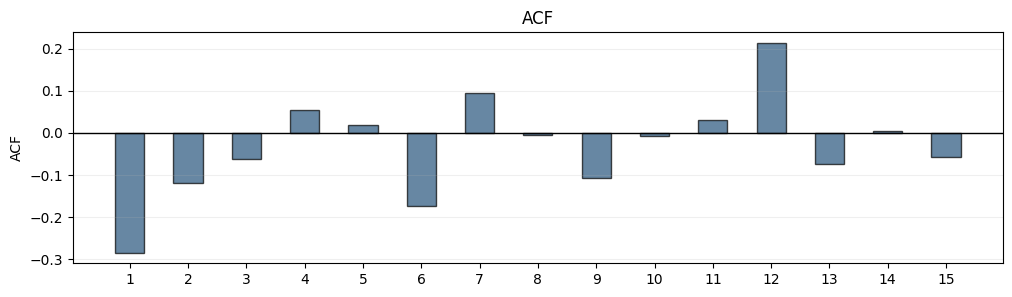

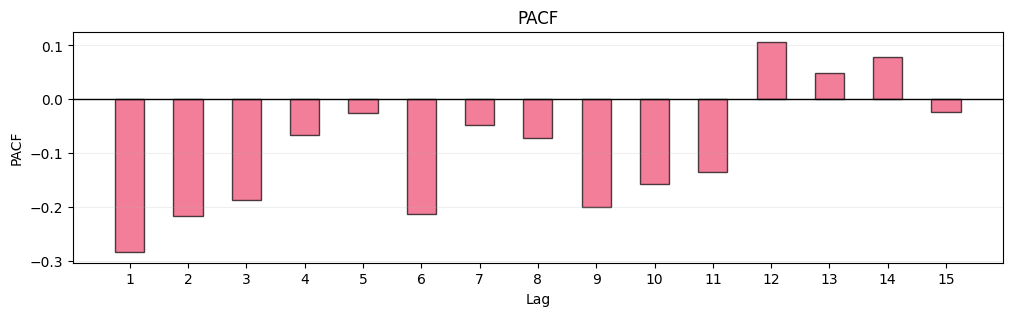

In [12]:
acf_to_plot = df_acf_pacf["ACF-built-in"].values[1:]
pacf_to_plot = df_acf_pacf["PACF-built-in"].values[1:]
lags = range(1, len(acf_to_plot)+1)

plt.figure(figsize=(12, 3))
plt.bar(lags, acf_to_plot, width=0.5, color="#26547c", alpha=0.7, edgecolor="black")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(lags)
plt.ylabel("ACF")
plt.grid(axis="y", linestyle="-", alpha=0.2)
plt.title("ACF")
plt.show()

plt.figure(figsize=(12, 3))
plt.bar(lags, pacf_to_plot, width=0.5, color="#ef476f", alpha=0.7, edgecolor="black")
plt.axhline(0, color="black", linewidth=1)
plt.xticks(lags)
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.grid(axis="y", linestyle="-", alpha=0.2)
plt.title("PACF")
plt.show()

#### *Conclusion*

*Calculating the first 15 `ACF` values manually has identical results to those found through python. Regarding `PACF`, the first and second values also coincided, but the third has a slight `deviation: -0.197242 \ -0.187796` which may be due to the peculiarities of the calculations in the built-in function.*

*The `ACF` plot shows a high correlation with `lag 1`, which is expected. There is also a high negative correlation with `lag 6 months` and `12 months`, which can be explained by the holidays every `6 months` (summer and winter).*

*Since the `12-month lag` in the `PACF` is not as significant as in the `ACF`, it can be assumed that the correlation is explained by more short-term intervals. The `PACF` has high correlations at `1, 2, 3 months`, `half-year lags`, and `9, 10, 11 lags`, respectively.*

*To sum up, `ACF` and `PACF` results suggest that time series has repeating seasonal ups and down rather than a smooth monotone trend.*

&nbsp;

### 2) Spectral analysis.

##### Power Spectral Density with Welch method

In [13]:
views = df['Views'].dropna().values

In [14]:
f_welch, Pxx_welch = welch(views, nperseg=len(views)//2, scaling='density')
nonzero = f_welch > 0
periods = 1 / f_welch[nonzero]
Pxx_valid = Pxx_welch[nonzero]

##### Plot (Spectral Density):
* x-axis - frequency value per month.
* y-axis - frequency contribution value to time series.

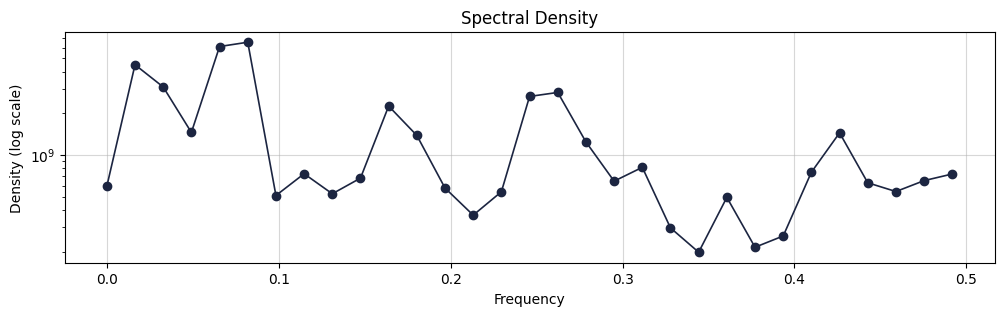

In [15]:
plt.figure(figsize=(12, 3))
plt.semilogy(f_welch, Pxx_welch, linewidth=1.2, color="#1c2541", marker='o', markersize=6)
plt.title("Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Density (log scale)")
plt.grid(alpha=0.5)
plt.show()

##### Plot (Period in Months):
* x-axis - period (cycle) lengths instead of frequency value.
* y-axis - period (cycle) contribution value to time series.

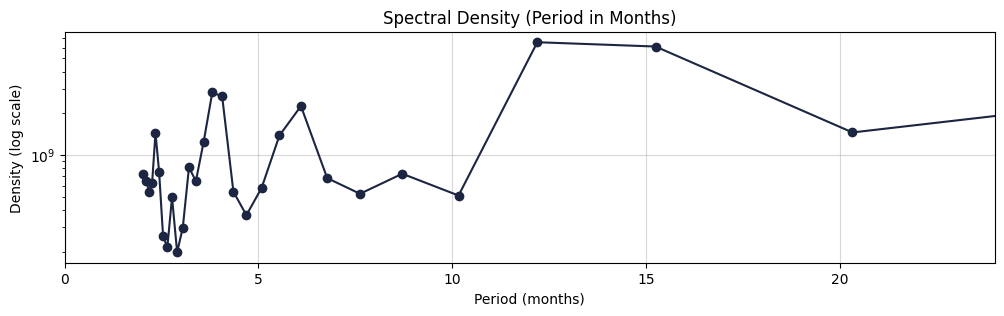

In [16]:
plt.figure(figsize=(12, 3))
plt.semilogy(periods, Pxx_valid,
             linewidth=1.5, color="#1c2541", marker='o', markersize=6)
plt.title("Spectral Density (Period in Months)", fontsize=12)
plt.xlabel("Period (months)")
plt.ylabel("Density (log scale)")
plt.grid(alpha=0.5)

plt.xlim(0, 24)
plt.show()

#### *Conclusion*
*As a normal `periodogram` gave me weird results, I sticked to `Welch method`. Its mooths out the noise and gives more useful results.
The `Welch method` plot showed confusing fluctuations in short periods (about `three months`). However, clear cycles were also highlighted such as: a period of `6 months` and around `12-15 months`.*

&nbsp;

### 3) Additional research.

#### a) Rolling Correlation (12 month lag)

To analyze 12-month cycle relationship over time.

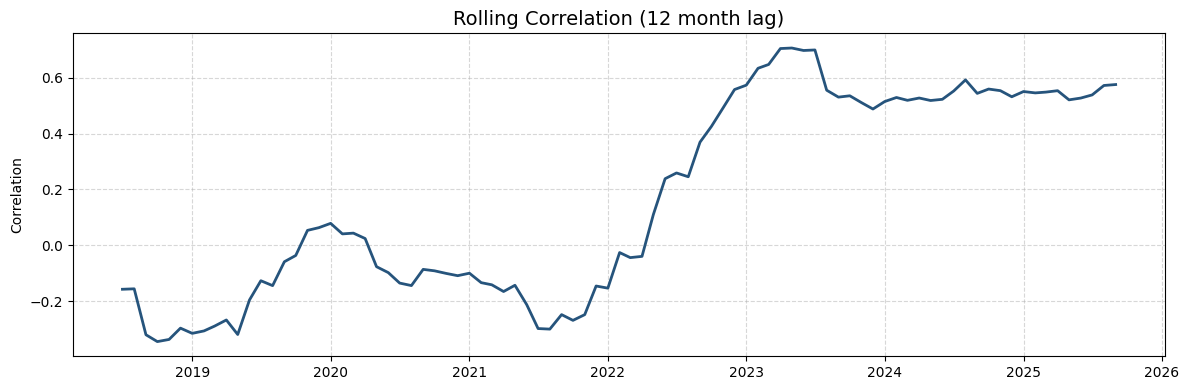

In [36]:
log_diff = df['Log_Diff'].dropna()
log_diff_laged = log_diff.shift(12)
rolling_corr = log_diff.rolling(24).corr(log_diff_laged)

plt.figure(figsize=(12,4))
plt.plot(rolling_corr.index, rolling_corr, color="#26547c", linewidth=2)
plt.title(f'Rolling Correlation (12 month lag)', fontsize=14)
plt.ylabel('Correlation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### b) Short-Time Fourier Transform

To analyze what cycles are there over the series. It shows what frequancy each cycle has and how strong it is.

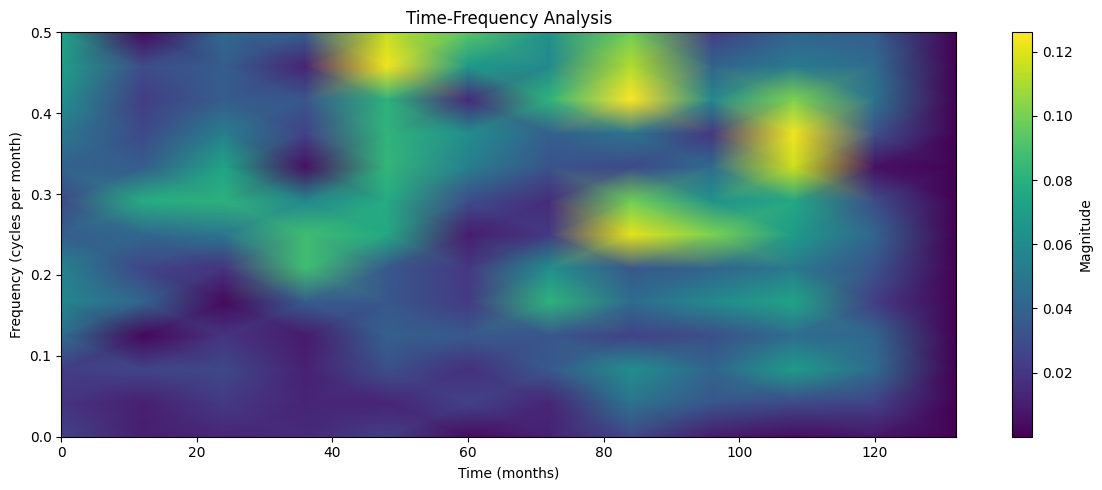

In [38]:
log_diff = df['Log_Diff'].dropna().values

# fs=1 (one sample per month)
f, t, Zxx = stft(log_diff, fs=1, nperseg=24)  

plt.figure(figsize=(12,5))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='viridis')
plt.title('Time-Frequency Analysis')
plt.ylabel('Frequency (cycles per month)')
plt.xlabel('Time (months)')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

#### *Conclusion*
*`Rolling Correlation` was used to look at the relationship between data with a difference of `one year`. As we can see in the graph, it has a small jump in `2020` and a consistently high annual correlation somewhere in `2022`. That is, from `2022` onwards the time series has data that behaves quite similarly every year.*

*`Short-Time Fourier Transform` was also used, which helps to see what `cycles` the series has in different places, how `long` and `strong` they are. From the pcolormesh graph, both `4-month` cycles and shorter ones with a length of `1-2 months` stand out. As with previous studies, it is clear that the time series is a little different in the second half, because it also has more cyclical connections in this part of the series*

&nbsp;